In [0]:
import os
from os import listdir
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets

from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import time

import matplotlib.pyplot as plt

 Load things from our shared project repository

In [0]:
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = ('drive/My Drive/LSGAN-Project')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Parameters go here

In [0]:
n_epochs = 100
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
latent_dim = 1024
img_size = 32
channels = 1
sample_interval = 400

In [0]:
img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False

In [0]:
int(np.prod(img_shape))

1024

Make sure your runtime is set to GPU for this to be true

In [0]:
cuda

True

# Our Implementation

Let's implement our own GAN with minor changes from the architecture proposed in paper. 

THIS IS OUR OWN CODE.

**If I commented out a layer, it was because it was taking very long to train**

In [0]:
class Our_Generator(nn.Module):
    def __init__(self, batch_norm = True, momentum = .1):
        super(Our_Generator, self).__init__()
        
        self.init_size = img_size // 4

        def linear_block(in_feat, out_feat, normalize=batch_norm):
            layers = [nn.Linear(in_feat, out_feat)]
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, momentum = momentum))
            return layers

        # as specified in paper
        def deconv_block(input_channels, output_channels, kernel_size, stride, padding, output_padding, normalize=batch_norm):
            layers = [nn.ConvTranspose2d(input_channels, output_channels, kernel_size = kernel_size, stride = stride, padding = padding, output_padding = output_padding)]
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            if normalize:
                layers.append(nn.BatchNorm2d(output_channels, momentum = momentum))
            return layers


        self.first_layer = nn.Sequential(
            *linear_block(latent_dim, 128 *  self.init_size**2)
        )

        # formula to keep 2D images the same size FOR CONVENIENCE
        # https://discuss.pytorch.org/t/how-to-keep-the-shape-of-input-and-output-same-when-dilation-conv/14338/2

        # I used this formula to keep the Image Sizes the same for deconvolutional layers
        # https://www.wolframalpha.com/input/?i=28+%3D+%2828+-+1%29+*+1+-2Z+%2B++P+%2B+%283-1%29+%2B+1

        # FORMULA FOR SIZE OF CONVOLUTIONAL AND DECONV LAYERS ARE DIFFERENT

        self.deconvolutional_part = nn.Sequential(
                *deconv_block(128, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
                *deconv_block(128, 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
                # Taking really long to train
                # Very last deconv part, needs to be right size of image
                # channels is 1 for mnist, 3 for colored datasets
                # NO batch norm here, always
                nn.Conv2d(64, channels, 3, stride = 1, padding = 1),
                # Can switch to Tanh for LSGAN if needed
                nn.Tanh()
        )

    def forward(self, z):
        out = self.first_layer(z)
        out = out.view(out.shape[0], 128,  self.init_size,  self.init_size)
        img = self.deconvolutional_part(out)
        return img


class Our_Discriminator(nn.Module):
    def __init__(self, batch_norm = True, momentum = .1):
        super(Our_Discriminator, self).__init__()

        def conv_block(in_filters, out_filters, kernel_size, stride, padding = 0, bn=batch_norm):
            block = [nn.Conv2d(in_filters, out_filters, kernel_size, stride, padding)]
            block.append(nn.LeakyReLU(0.2, inplace=True))
            if bn:
                block.append(nn.BatchNorm2d(out_filters, momentum = momentum))
            return block


        # FORMULA FOR SIZE OF CONVOLUTIONAL AND DECONV LAYERS ARE DIFFERENT
        # We don't have to keep image size same, but do it for convenience of knowing
        # size of last layer
        self.model = nn.Sequential(
            # change from kernel size from 5 to 4 to make padding an integer
            # and keep image size the same
            *conv_block(channels, 16, 3, stride = 2, padding = 1, bn = False),
            *conv_block(16, 32, 3, stride = 2, padding = 1),
            *conv_block(32, 64, 3, stride = 2, padding = 1),
            #*conv_block(64, 128, 4, stride = 2, padding = 15),
            #*conv_block(128, 256, 4, stride = 2, padding = 15),
            #*conv_block(256, 512, 4, stride = 2, padding = 15),
        )

        ds_size = img_size // 2 ** 3
        self.adv_layer = nn.Sequential(
            # Keep  Linear part only for LSGAN
            nn.Linear(64 * ds_size ** 2, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [0]:
# Loss function
adversarial_loss = torch.nn.BCELoss() # GAN

# Initialize generator and discriminator
our_generator = Our_Generator(batch_norm = True, momentum = .1)
our_discriminator = Our_Discriminator(batch_norm = True, momentum = .1)

In [0]:
if cuda:
    our_generator.cuda()
    our_discriminator.cuda()
    adversarial_loss.cuda()

In [0]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

our_generator.apply(weights_init_normal)
our_discriminator.apply(weights_init_normal)

Our_Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (adv_layer): Sequential(
    (0): Linear(in_features=1024, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [0]:
BASE_DIR + '/data/mnist/train'

'drive/My Drive/LSGAN-Project/data/mnist/train'

In [0]:
fashion_dataloader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        BASE_DIR + '/data/fashion-mnist/train',
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)


In [0]:
optimizer_our_G = torch.optim.Adam(our_generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_our_D = torch.optim.Adam(our_discriminator.parameters(), lr=lr, betas=(b1, b2))

In [0]:
# CUDA tensor or not
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# to fix a bug in save images
#listdir(BASE_DIR + "/data/our_gan/fashion-mnist/images/")

In [0]:
# SAVE MODEL
model_subfolder = BASE_DIR + '/data/our_gan/batch-after-ReLU-fashion-mnist/'
try:
  os.makedirs(model_subfolder) # will throw error if subfolder already exists
except:
  pass
try:
  os.makedirs(model_subfolder + 'images/') # will throw error if subfolder already exists
except:
  pass
print(model_subfolder)

drive/My Drive/LSGAN-Project/data/our_gan/batch-after-ReLU-fashion-mnist/


In [0]:
# ----------
#  Training
# ----------
start_time = time.time()
n_epochs = 200
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(fashion_dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_our_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        gen_imgs = our_generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(our_discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_our_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_our_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(our_discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(our_discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_our_D.step()
        if i % 400 == 0: 
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, n_epochs, i, len(fashion_dataloader), d_loss.item(), g_loss.item())
            )

        batches_done = epoch * len(fashion_dataloader) + i
        if batches_done % sample_interval == 0:
            save_image(gen_imgs.data[:25], model_subfolder + "images/%d.png" % batches_done, nrow=5, normalize=False)


end_time = time.time()

[Epoch 0/200] [Batch 0/938] [D loss: 0.854200] [G loss: 0.279629]
[Epoch 0/200] [Batch 400/938] [D loss: 0.263380] [G loss: 2.287619]
[Epoch 0/200] [Batch 800/938] [D loss: 0.252657] [G loss: 1.308203]
[Epoch 1/200] [Batch 0/938] [D loss: 0.236329] [G loss: 1.409265]
[Epoch 1/200] [Batch 400/938] [D loss: 0.074062] [G loss: 2.561901]
[Epoch 1/200] [Batch 800/938] [D loss: 0.081581] [G loss: 3.522579]
[Epoch 2/200] [Batch 0/938] [D loss: 0.041991] [G loss: 3.360577]
[Epoch 2/200] [Batch 400/938] [D loss: 0.047636] [G loss: 3.504933]
[Epoch 2/200] [Batch 800/938] [D loss: 0.026931] [G loss: 3.916074]
[Epoch 3/200] [Batch 0/938] [D loss: 0.107119] [G loss: 3.680813]
[Epoch 3/200] [Batch 400/938] [D loss: 0.017037] [G loss: 4.308843]
[Epoch 3/200] [Batch 800/938] [D loss: 0.011617] [G loss: 4.876121]
[Epoch 4/200] [Batch 0/938] [D loss: 0.192057] [G loss: 1.887377]
[Epoch 4/200] [Batch 400/938] [D loss: 0.370300] [G loss: 1.227121]
[Epoch 4/200] [Batch 800/938] [D loss: 0.045103] [G loss: 

In [0]:
print("Took this long")
print(end_time - start_time)

Took this long
8037.419832229614


In [0]:
# https://pytorch.org/tutorials/beginner/saving_loading_models.html
listdir(model_subfolder)
torch.save(our_generator.state_dict(), model_subfolder + 'generator.pt')
torch.save(our_discriminator.state_dict(), model_subfolder + 'discriminator.pt')

Test how we do on the last train batch

# Evaluation

In [0]:
results_on_fake_images = our_discriminator(our_generator(z))
results_on_fake_images.mean()

tensor(0.0126, device='cuda:0', grad_fn=<MeanBackward0>)

In [0]:
real_imgs = Variable(imgs.type(Tensor))
results_on_real_images = our_discriminator(real_imgs)
results_on_real_images.mean()

tensor(0.9987, device='cuda:0', grad_fn=<MeanBackward0>)

In [0]:
fake_img_1 = our_generator(z)[0][0]

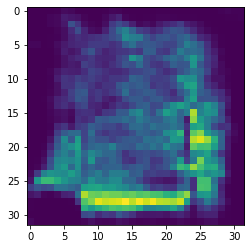

In [0]:
plt.imshow(fake_img_1.cpu().detach().numpy())

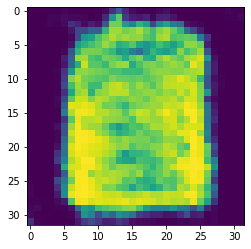

In [0]:
fake_img_2 = our_generator(z)[1][0]
plt.imshow(fake_img_2.cpu().detach().numpy())

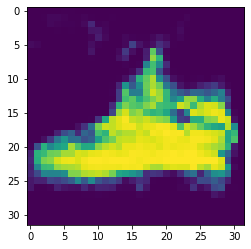

In [0]:
fake_img_2 = our_generator(z)[2][0]
plt.imshow(fake_img_2.cpu().detach().numpy())

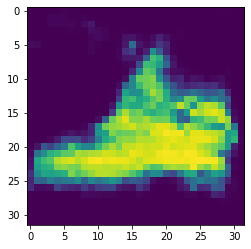

In [0]:
fake_img_2 = our_generator(z)[3][0]
plt.imshow(fake_img_2.cpu().detach().numpy())

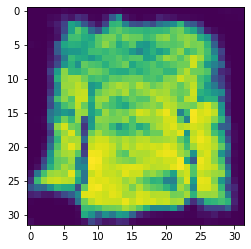

In [0]:
fake_img_2 = our_generator(z)[4][0]
plt.imshow(fake_img_2.cpu().detach().numpy())

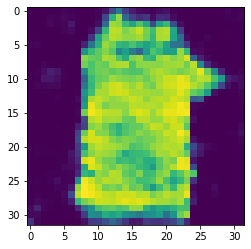

In [0]:
fake_img_2 = our_generator(z)[5][0]
plt.imshow(fake_img_2.cpu().detach().numpy())

In [0]:
#our_generator = GAN_Generator(batch_norm = False)
#our_generator.load_state_dict(torch.load(BASE_DIR + "/data/our_gan/no_batch_norm_fashion_mnist/WORKING_generator.pt"))
#our_generator.eval()
#our_generator.cuda()

#our_discriminator = GAN_Discriminator(batch_norm = False)
#our_discriminator.load_state_dict(torch.load(BASE_DIR + "/data/our_gan/no_batch_norm_fashion_mnist/WORKING_discriminator.pt"))
#our_discriminator.eval()
#our_discriminator.cuda()